In [1]:
# Se importan los paquetes necesarios:

import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math
from dateutil.relativedelta import relativedelta

%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Me sitúo en la carpeta donde están los ficheros de entrada**

In [2]:
cd \Users\mbpablo\Desktop\TFM\Ficheros_entrada\

C:\Users\mbpablo\Desktop\TFM\Ficheros_entrada


## 1. Importación mensual del fichero:

Para la obtención de los datos se crea la función `importacion_datos()`, que va acumulando los datos extraídos mes a mes en un dataframe llamado **_datos:_**

In [3]:
# Se visualizan todas las variables del dataset

pd.set_option('display.max_columns', 500)

In [4]:
lista_de_datos = ('ENE','FEB','MAR','ABR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC')

In [5]:
# Se importan los ficheros mensuales:

def importacion_datos(lista_de_datos):
    
    """ Se crea un fichero donde se irán acumulando las extracciones mensuales.
    Se elige esta manera de hacerlo porque no todos los meses tienen la misma estructura de variables """
  
    datos = []
  
    for file in lista_de_datos:

        datos.append(pd.read_csv(file + '_v2_2018.tab', 
           sep='\t', encoding='latin-1', engine='python', error_bad_lines=False, 
           na_values=[np.nan, 'nan', 'NONE', -999, ''], parse_dates=['VAR_27','VAR_28']))
    
        df = pd.concat(datos, sort=True)
    
    return df

In [6]:
A = importacion_datos(lista_de_datos)
A.head(3)

,VAR_01,VAR_02,VAR_03,VAR_04,VAR_05,VAR_06,VAR_07,VAR_08,VAR_09,VAR_10,VAR_11,VAR_12,VAR_13,VAR_14,VAR_15,VAR_16,VAR_17,VAR_18,VAR_19,VAR_20,VAR_21,VAR_22,VAR_23,VAR_24,VAR_25,VAR_26,VAR_27,VAR_28,VAR_29,VAR_30,VAR_31,VAR_32,VAR_33,VAR_34,VAR_35,VAR_36,VAR_37,VAR_38,VAR_39,VAR_40,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78,VAR_79,VAR_80,VAR_81,VAR_82,VAR_83,VAR_84,VAR_85,VAR_86,VAR_87,VAR_88,VAR_89,VAR_90,VAR_91,VAR_92,VAR_93,VAR_94
0,1,3 años,Question Not Shown To Visitor,Entre 4 y 5 años,3 años,3 años,1.0,1,1,26 25 años,1,28018,100001,1,0,0,0,0,0,1,1,1.0,1,0,0,0,2018-01-15,1974-05-14,Este mes,1,1,0,0,0,NaN,1,2,3,1,1,28,0,O,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,11.0,0,0,0,1
1,2,más de 10,Question Not Shown To Visitor,Entre 10 y 25 años,más de 10,más de 10,0.0,2,2,24 23 años,1,7141,100009,2,1,0,0,0,0,1,2,1.0,0,1,0,1,2018-01-19,1976-08-23,Hace 11 meses,1,2,0,0,0,NaN,1,2,1,2,1,7,0,L,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,7.0,0,0,0,1
2,2,más de 10,Question Not Shown To Visitor,Entre 10 y 25 años,Sin Accidentes,más de 10,0.0,2,3,18 17 años,1,10005,100009,3,0,0,0,0,0,1,2,NaN,0,0,0,1,2018-08-01,1981-01-23,Dentro de 1 mes,0,3,0,0,0,NaN,1,1,1,3,1,10,0,L,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,7,1,1,8.0,0,0,0,1


In [7]:
# Se observa el tamaño del dataset:

A.shape

(108406, 94)

In [8]:
# Se comprueba que la importación de los ficheros mensuales no haya generado registros duplicados:

A.shape[0] == A.drop_duplicates().shape[0]

True

In [9]:
# Una vez comprobado que la importación mensual se realiza correctamente se elimina la VAR_35:

A = A.drop('VAR_35', axis=1)

In [10]:
# Se comprueban los tipos de variables:

A.dtypes

VAR_01             int64
VAR_02            object
VAR_03            object
VAR_04            object
VAR_05            object
VAR_06            object
VAR_07           float64
VAR_08             int64
VAR_09             int64
VAR_10            object
VAR_11             int64
VAR_12             int64
VAR_13             int64
VAR_14             int64
VAR_15             int64
VAR_16             int64
VAR_17             int64
VAR_18             int64
VAR_19             int64
VAR_20             int64
VAR_21             int64
VAR_22           float64
VAR_23             int64
VAR_24             int64
VAR_25             int64
VAR_26             int64
VAR_27    datetime64[ns]
VAR_28    datetime64[ns]
VAR_29            object
VAR_30             int64
               ...      
VAR_65             int64
VAR_66             int64
VAR_67             int64
VAR_68             int64
VAR_69             int64
VAR_70             int64
VAR_71             int64
VAR_72             int64
VAR_73             int64


In [11]:
A.columns[A.isnull().sum()!=0]

Index(['VAR_07', 'VAR_10', 'VAR_22', 'VAR_43', 'VAR_90'], dtype='object')

In [12]:
# Se definen como string las variables que van a ser tratadas como categóricas:
      
dtype_columns = ['VAR_01', 'VAR_08', 'VAR_09', 'VAR_11', 'VAR_12', 'VAR_13', 'VAR_14', 'VAR_15', 'VAR_16', 'VAR_17', 
                 'VAR_18', 'VAR_19', 'VAR_20', 'VAR_21', 'VAR_22', 'VAR_23', 'VAR_24', 'VAR_25', 'VAR_26', 'VAR_30',
                 'VAR_31', 'VAR_36', 'VAR_38', 'VAR_39', 'VAR_40', 'VAR_41', 'VAR_42', 'VAR_44', 'VAR_45',
                 'VAR_46', 'VAR_47', 'VAR_48', 'VAR_49', 'VAR_50', 'VAR_51', 'VAR_52', 'VAR_53', 'VAR_54','VAR_55',
                 'VAR_56', 'VAR_57', 'VAR_58', 'VAR_59', 'VAR_60', 'VAR_61', 'VAR_62', 'VAR_63', 'VAR_64','VAR_65',
                 'VAR_66', 'VAR_67', 'VAR_68', 'VAR_69', 'VAR_70', 'VAR_71', 'VAR_72', 'VAR_73', 'VAR_74','VAR_75',
                 'VAR_76', 'VAR_77', 'VAR_78', 'VAR_79', 'VAR_80', 'VAR_81', 'VAR_82', 'VAR_83', 'VAR_84','VAR_85',
                 'VAR_86', 'VAR_88', 'VAR_89', 'VAR_90', 'VAR_94']
      
A.loc[:, dtype_columns] = A.loc[:, dtype_columns].astype('str')


In [13]:
A.columns[A.isnull().sum()!=0]

Index(['VAR_07', 'VAR_10', 'VAR_43'], dtype='object')

Al pasar las variables con formato float a string, se han transformado los NaN en 'nan', por lo que la función `isnull()` no los detecta como missing.

Tenemos que forzar a NaN los valores missing de las features VAR_22 y VAR_90.

In [14]:
vars_a_cambiar = ['VAR_22', 'VAR_90']

for x in (vars_a_cambiar):
    A[x] = A[x].replace('nan', np.nan)

Como se observa a continuación, aplicando la función `vars_a_cambiar()`, las features VAR_22 y VAR_90 vuelven a tener missing values.

In [15]:
 A.columns[A.isnull().sum()!=0]

Index(['VAR_07', 'VAR_10', 'VAR_22', 'VAR_43', 'VAR_90'], dtype='object')

### 1.2 Se añade información adicional procedente del catálogo de vehículos:

In [16]:
T_CATALOGO = pd.read_csv('CATALOGO_v2_112018_TFM.txt', sep='\t', engine='python')

dtype_cat_columns = ['VAR_13', 'VAR_95', 'VAR_96', 'VAR_97', 'VAR_98', 'VAR_101', 'VAR_103']

T_CATALOGO.loc[:, dtype_cat_columns] = T_CATALOGO.loc[:, dtype_cat_columns].astype('str')

T_CATALOGO.head(2)

,VAR_13,VAR_95,VAR_96,VAR_97,VAR_98,VAR_99,VAR_100,VAR_101,VAR_102,VAR_103,VAR_104,VAR_105
0,1,4,0.0,5,5,1569,74,0.0,0,0,5553.35,0
1,2,2,0.0,5,5,1490,95,0.0,0,0,12020.24,0


In [17]:
# Se añade información adicional procedente del catálogo de vehículos:

A_cat = A.merge(T_CATALOGO, how='left', left_on=['VAR_13'], right_on=['VAR_13'])

# Se comprueba que el cruce es correcto, ya que el dataset de salida tiene las mismas columnas del de entrada:

A.shape[0] == A_cat.shape[0]

True

## 2.Tratamiento de variables:

In [18]:
# Se calcula la VAR_106 (edad) como la diferencia entre VAR_27 y var_28 para disponer de esta variable en forma continua:

A_cat.loc[:,'VAR_106'] = A_cat.apply(lambda x: relativedelta(x['VAR_27'],x['VAR_28'])\
                                            .years, axis=1).values

In [19]:
A_cat['VAR_106'].dtypes

dtype('int64')

In [20]:
A_cat['VAR_106'].head()

0    43
1    41
2    37
3    43
4    27
Name: VAR_106, dtype: int64

### 2.1 Se estudian los missing values:

El primer paso al evaluar los missing values es comprobar si el target tiene o no valores ausentes:

In [21]:
A_cat['VAR_43'].isnull().sum()

3227

El Scoring es el target, y, aproximadamente, un 3% de sus valores son missing. Estos registros serán eliminados, ya que que **no tiene sentido mantener en el dataset aquellos registros donde el target no está correctamente informado**.

In [22]:
# Se eliminan los valores del target que son nan:

A_cat = A_cat.loc[(A_cat['VAR_43'].isnull() == False),:]

Una vez hecho esto, obtenemos las features que tienen missing values y después observaremos el número de ellos y cuánto representan sobre el total para decidir cómo son tratados.

In [23]:
Columns_missing_values = A_cat.columns[A_cat.isnull().sum()!=0]
Columns_missing_values

Index(['VAR_07', 'VAR_10', 'VAR_22', 'VAR_90', 'VAR_95', 'VAR_96', 'VAR_97',
       'VAR_98', 'VAR_99', 'VAR_100', 'VAR_101', 'VAR_102', 'VAR_103',
       'VAR_104', 'VAR_105'],
      dtype='object')

In [24]:
df_missing_values = A_cat[Columns_missing_values]

In [25]:
#Total de missing values

total_missing_val = df_missing_values.isnull().sum().sort_values(ascending = False)

#Porcentaje que representa sobre el total de datos

por_missing_val = (df_missing_values.isnull().sum() / df_missing_values.isnull().count()).sort_values(ascending = False)

missing_data = pd.concat([total_missing_val, por_missing_val], axis = 1, keys = ['Total', 'Porcentaje'])
missing_data.head(10)

,Total,Porcentaje
VAR_10,2478,0.023560
VAR_22,1138,0.010820
VAR_90,294,0.002795
VAR_105,10,0.000095
VAR_104,10,0.000095
VAR_103,10,0.000095
VAR_102,10,0.000095
VAR_101,10,0.000095
VAR_100,10,0.000095
VAR_99,10,0.000095


Para tratar los missing values restantes se crean **dos listas:**

* La primera de ellas contendrá las variables discretas, a cuyos missing values imputaremos la moda.

* La segunda contendrá las variables continuas a cuyos missing values le asignaremos el valor válido inmediatamente anterior.
  Se decide este método de imputación porque la mayoría de estas variables son de tipo entero y, si les asignásemos la media,
  estaríamos imputando valores no enteros.

In [26]:
# Se seleccionan las variables discretas:

df_missing_values_obj = df_missing_values.loc[:,(df_missing_values.columns[df_missing_values.dtypes == object])]
df_missing_values_obj.sample(2)

,VAR_10,VAR_22,VAR_90,VAR_95,VAR_96,VAR_97,VAR_98,VAR_101,VAR_103
91728,21 20 años,2.0,7.0,1,1.0,5,5,1.0,5
104364,27 Más de 25 años,1.0,9.0,2,0.0,4,5,0.0,0


In [27]:
# Se halla la moda (o valor más frecuente) de las features discretas:

var_discretas = df_missing_values.columns[df_missing_values.dtypes == object]

A_cat.loc[:,var_discretas].mode()

,VAR_10,VAR_22,VAR_90,VAR_95,VAR_96,VAR_97,VAR_98,VAR_101,VAR_103
0,27 Más de 25 años,1.0,9.0,2,0.0,5,5,1.0,0


Con la moda, se crea un diccionario y se imputan los missing values de las variables discretas mediante la función `fillna()`:

In [28]:
dict_var_disc = A_cat.loc[:,var_discretas].mode().T.to_dict()[0]

A_cat.loc[:,var_discretas] = A_cat.loc[:,var_discretas].fillna(value=dict_var_disc)

In [29]:
# Se seleccionan aquellas features de tipo continuo:

df_missing_values_cont = df_missing_values.loc[:,(df_missing_values.columns[df_missing_values.dtypes != object])]
df_missing_values_cont.sample(2)

,VAR_07,VAR_99,VAR_100,VAR_102,VAR_104,VAR_105
90990,12.0,1251.0,70.0,0.0,12720.0,0.0
54897,12.0,1587.0,110.0,126.0,18160.0,0.0


In [30]:
var_continuas = df_missing_values.columns[df_missing_values.dtypes != object]

In [31]:
A_cat.loc[:,var_continuas] = A_cat.loc[:,var_continuas].fillna(method='ffill')

In [32]:
A_cat.shape

(105179, 105)

In [33]:
# Se comprueba que ya no hay missing values:

print(A_cat.shape);

print(A_cat.isnull().sum().shape);

(105179, 105)
(105,)


## 3. Análisis del target:

In [34]:
A_cat.groupby('VAR_43')['VAR_43'].count()

VAR_43
2        1
3       28
4      104
5       84
6       36
A     2515
B     2321
C     1004
D     1889
E      704
F      685
G     2269
H     7257
I     5360
J     8109
K     8425
L    11951
M    11864
N    29024
O    11066
P      481
Q        2
Name: VAR_43, dtype: int64

El target es una variable que tiene 23 niveles, algunos de ellos con muy poca masa, por lo que **se opta por hacer 4 agrupaciones:**
    
    1. Score_alto: 6,G,H
    2. Score_medio: 5,L,K,J,I,4,N,M
    3. Score_bajo: 3,O,P,1,2
    4. ASNEF: A, B, C, D y F    

In [35]:
def target_nivelado (x):
    
    if x in ("6","5","G","H","I","J","K","L"):
        return "1"      
    elif x in ("4","N","M"):
        return "2"   
    elif x in ("3","O","P","Q","1","2"):
        return "3"    
    elif x in ("A","B","C","D","E","F"):
        return "4"
    else:
        return 5
    
A_cat.loc[:,"VAR_43_NIVELADO"] = A_cat["VAR_43"].apply(lambda x: target_nivelado(x))

In [36]:
# Ahora los 4 grupos creados son más representativos:

A_cat.groupby('VAR_43_NIVELADO')['VAR_43_NIVELADO'].agg({'Nº de registros':'count'})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,Nº de registros
VAR_43_NIVELADO,
1,43491
2,40992
3,11578
4,9118


## 4. Análisis de variables:

###  A) Numéricas:

In [37]:
A_cat.describe()

,VAR_07,VAR_99,VAR_100,VAR_102,VAR_104,VAR_105,VAR_106
count,105179.000000,105179.000000,105179.000000,105179.000000,105179.000000,105179.000000,105179.000000
mean,8.299841,1716.865420,119.266517,90.146550,23655.928911,18.573888,40.517936
std,7.019539,481.424985,44.862607,65.717932,11913.599490,43.879541,11.596211
min,0.000000,0.000000,23.000000,0.000000,2404.050000,0.000000,17.000000
25%,1.000000,1399.000000,90.000000,0.000000,16475.000000,0.000000,32.000000
50%,8.000000,1598.000000,110.000000,113.000000,21585.000000,0.000000,39.000000
75%,13.000000,1968.000000,137.000000,135.000000,27592.470000,28.000000,48.000000
max,102.000000,7237.000000,700.000000,420.000000,298204.000000,374.000000,100.000000


In [38]:
# Función para crear boxplots con Seaborn:

def bxp (x):
    return sns.boxplot(data=A_cat[x]);

#### VAR_07:

Se dibuja el boxplot para observar la distribución de los valores de la variable VAR_07.

Esta variable puede tener valor 0, pero no parece posible que tenga un valor máximo de 102 años. 

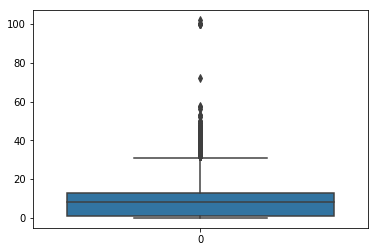

In [39]:
# Se dibuja el boxplot para ver la distribución de los valores:

bxp('VAR_07');

In [40]:
# Se observa el peso de los registros de la variable cuyos valores superiores a 40:

print((A_cat.loc[(A_cat['VAR_07']>40),'VAR_07'].count() / A_cat.shape[0]) * 100)

0.10553437473259872


In [41]:
# Es un 0,10% de los registros, por lo que se opta por eliminarlos:

A_cat = A_cat.loc[(A_cat['VAR_07'] <= 40),:]

#### VAR_106:

Aunque no sea común, esta variable podría tener valores aislados próximos a 100, sin embargo no puede tener un valor menor a 18. 

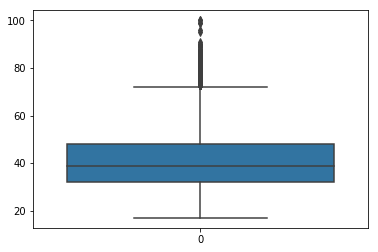

In [42]:
# Se dibuja el boxplot para ver la distribución de los valores:

bxp('VAR_106');

In [43]:
# Se observa el peso de los registros de la variable cuyos valores son menores a 0:

print((A_cat.loc[(A_cat['VAR_106'] < 18),'VAR_106'].count() / A_cat.shape[0]) * 100)

0.01142117485818708


In [44]:
# Estos valores supoenen el 0,012% de los registros:

A_cat = A_cat.loc[(A_cat['VAR_106'] != 0),:]

#### VAR_100, VAR_102, VAR_104 Y VAR_105 

Tienen valores extremos pero están informados correctamente, por lo que se decide conservarlos.

### B) Categóricas

**La siguientes funciónes se crean con el objetivo de estudiar la distribución de frecuencias de cada variable categórica.**

- `info_vars()` se crea para analizar los estadísticos básicos de cada variable.
- `dist_freq()` elabora para observar la distribución de cada una de ellas.

Analizando la información proporcionada por ambas funciones se decidirá la forma de actuar sobre cada variable.

A continuación se muestra la lista de variables que se van a analizar:

In [45]:
# Se define la lista de variables categóricas que se quieren observar:

lista_cat = ['VAR_01', 'VAR_02', 'VAR_03', 'VAR_04', 'VAR_05', 'VAR_06', 'VAR_08', 'VAR_09', 'VAR_10', 'VAR_11', 'VAR_14',
             'VAR_15', 'VAR_20', 'VAR_21', 'VAR_23', 'VAR_24', 'VAR_25', 'VAR_26', 'VAR_29', 'VAR_30', 'VAR_31', 'VAR_32',
             'VAR_33', 'VAR_34', 'VAR_36', 'VAR_37', 'VAR_38', 'VAR_39', 'VAR_40', 'VAR_41', 'VAR_42', 'VAR_88', 'VAR_89',
             'VAR_91', 'VAR_92', 'VAR_93', 'VAR_94', 'VAR_95', 'VAR_96', 'VAR_97', 'VAR_98', 'VAR_101','VAR_103']

In [46]:
# Se crea una función que da información básica de las variables categóricas:

def info_vars(x):
    
    print('Información de: ' + A_cat[x].name)
    print('Nº de registros: ' + str(A_cat[x].count()))
    print('Registros únicos: ' + str(A_cat[x].nunique()))
    print('Moda: ' + str(A_cat[x].mode().to_dict()[0]))
    print('Frecuencia de la moda: ' + str(int(round((A_cat.loc[(A_cat[x] == A_cat[x].mode().to_dict()[0]), x].count())\
                                        /(A_cat[x].count())*100))) + str('%'))
    print('Frecuencia media de los registros únicos (excepto la moda): ' + str(int(round((((A_cat[x].count())-\
                                                          (A_cat.loc[(A_cat[x] == A_cat[x].mode().to_dict()[0]), x]\
                                                          .count()))/A_cat[x].nunique())\
                                                          /(A_cat[x].count())*100))) + str('%'))
    print('\n')

In [47]:
# Se crea una función para observar la distribución de frecuencias:

def dist_freq(x):
    var_count = A_cat[x].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(var_count.index, var_count.values, alpha=0.9)
    plt.title('Distribución de frecuencias {}'.format(x))
    plt.ylabel('Ocurrencias', fontsize=12)
    plt.xlabel('', fontsize=12)
    plt.xticks(fontsize=10, rotation='vertical')
    plt.figure(figsize=(12, 8))
    return plt.show()

In [48]:
# Se crea una función que va generando la información básica de cada variable de la lista:

def get_dist_cat():
    for var in lista_cat:
        yield info_vars(var)

gen_dist_cat = get_dist_cat()

In [49]:
# Se crea una función que va generando la distribución de frecuencias de cada variable de la lista:

def get_plot_cat():
    for var in lista_cat:
        yield dist_freq(var)

gen_plot_cat = get_plot_cat()

Información de: VAR_01
Nº de registros: 105068
Registros únicos: 5
Moda: 3
Frecuencia de la moda: 53%
Frecuencia media de los registros únicos (excepto la moda): 9%




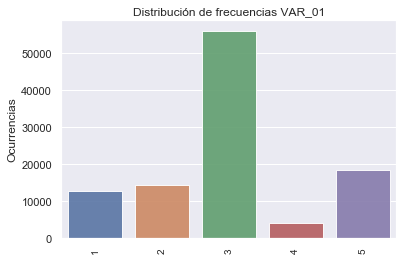

<Figure size 864x576 with 0 Axes>

In [50]:
# Ejecutar para graficar la siguiente variable:

next(gen_dist_cat);next(gen_plot_cat)

#### VAR_03:

Tiene 384 registros únicos con muy pocos valores por cada uno de ellos (0% en media), por lo que se opta por tratar la variable y realizar agrupaciones:

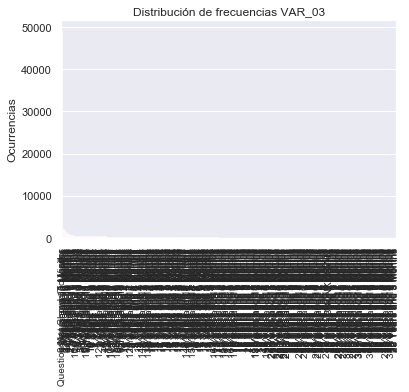

<Figure size 864x576 with 0 Axes>

Información de: VAR_03
Nº de registros: 105068
Registros únicos: 388
Moda: Question Not Shown To Visitor
Frecuencia de la moda: 47%
Frecuencia media de los registros únicos (excepto la moda): 0%




In [51]:
dist_freq('VAR_03')
info_vars('VAR_03')

In [52]:
# Con esta expresión regular se obtienen los primeros dos dígitos de cada registro:

A_cat.loc[:,'VAR_03_1'] = A_cat.apply(lambda x: re.findall("^\d{0,2}",x['VAR_03'])[0], axis=1)

In [53]:
# Con esta función se nivela VAR_03:

def var_03_func (x):

    if x == '' or x == 'Question NotShown To Visitor':
        return 'Question NotShown To Visitor'
    elif x == '0':
        return "0"
    elif x == '1':
        return "1"   
    elif x == '2':
        return "2"    
    elif x in ('3','4','5'):
        return "de 3 a 5"
    elif x in ('6','7','8','9','10'):
        return "de 6 a 10"
    elif x in ('11','12','13','14','15'):
        return "de 11 a 15" 
    else:
        return "mas de 15"
    
A_cat.loc[:,"VAR_03_2"] = A_cat["VAR_03_1"].apply(lambda x: var_03_func(x))

In [54]:
# Se comprueba que la función es correcta:

A_cat.groupby('VAR_03_2')['VAR_03_2'].count()

VAR_03_2
0                                7522
1                                8428
2                                6378
Question NotShown To Visitor    49129
de 11 a 15                       8656
de 3 a 5                        10499
de 6 a 10                       12050
mas de 15                        2406
Name: VAR_03_2, dtype: int64

In [55]:
# Se eliminan las variables intermedias:

A_cat = A_cat.drop(['VAR_03','VAR_03_1'], axis=1)
A_cat = A_cat.rename(columns={'VAR_03_2': 'VAR_03'})

#### VAR_09:

Tiene 52 registros únicos, algunos de ellos con muy pocos valores (2% en media), por lo que se opta por tratar la variable y agrupar los valores con un nº de registros inferior a 4000:

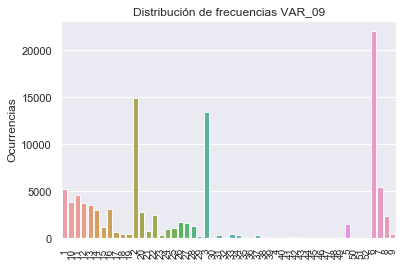

<Figure size 864x576 with 0 Axes>

Información de: VAR_09
Nº de registros: 105068
Registros únicos: 52
Moda: 6
Frecuencia de la moda: 21%
Frecuencia media de los registros únicos (excepto la moda): 2%




In [56]:
dist_freq('VAR_09')
info_vars('VAR_09')

In [57]:
A_cat.groupby('VAR_09')['VAR_09'].count().sort_values(ascending=False)

VAR_09
6     22056
2     14931
3     13459
7      5445
1      5202
11     4567
10     3791
12     3704
13     3544
16     3093
14     2970
20     2805
22     2466
8      2332
26     1739
27     1558
5      1511
28     1299
15     1198
25     1092
24      998
21      786
17      599
33      463
9       442
19      438
18      411
34      366
37      359
31      308
23      282
29      187
35      145
41      100
38       94
43       86
32       64
40       36
51       26
36       22
45       21
46       14
4        13
44       13
39        7
50        6
30        5
49        4
52        4
47        3
48        3
42        1
Name: VAR_09, dtype: int64

In [58]:
# Con esta función se nivela VAR_03:

def var_09_func (x):

    if x == '6':
        return "6"
    elif x == '2':
        return "2"
    elif x == '3':
        return "3"   
    elif x == '7':
        return "7"
    elif x == '1':
        return "1" 
    elif x == '11':
        return "11" 
    else:
        return "Resto"
    
A_cat.loc[:,"VAR_09_2"] = A_cat["VAR_09"].apply(lambda x: var_09_func(x))

In [59]:
# Se comprueba que la función es correcta:

A_cat.groupby('VAR_09_2')['VAR_09_2'].count()

VAR_09_2
1         5202
11        4567
2        14931
3        13459
6        22056
7         5445
Resto    39408
Name: VAR_09_2, dtype: int64

In [60]:
# Se eliminan las variables intermedias:

A_cat = A_cat.drop(['VAR_09'], axis=1)
A_cat = A_cat.rename(columns={'VAR_09_2': 'VAR_09'})

#### VAR_21:

Se agrupan el nivel 4 junto con el 2 por ser el que tiene una mayor exposición:

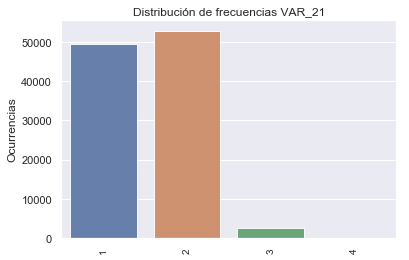

<Figure size 864x576 with 0 Axes>

Información de: VAR_21
Nº de registros: 105068
Registros únicos: 4
Moda: 2
Frecuencia de la moda: 50%
Frecuencia media de los registros únicos (excepto la moda): 12%




In [61]:
dist_freq('VAR_21')
info_vars('VAR_21')

In [62]:
# Con esta función se nivela VAR_03:

def var_21_func(x):

    if x == '1':
        return "1"
    elif x == '2':
        return "2"
    elif x == '3':
        return "3"   
    else:
        return "2"
    
A_cat.loc[:,"VAR_21_2"] = A_cat["VAR_21"].apply(lambda x: var_21_func(x))

In [63]:
# Se comprueba que la función es correcta:

A_cat.groupby('VAR_21_2')['VAR_21_2'].count()

VAR_21_2
1    49548
2    53002
3     2518
Name: VAR_21_2, dtype: int64

In [64]:
# Se eliminan las variables intermedias:

A_cat = A_cat.drop(['VAR_21'], axis=1)
A_cat = A_cat.rename(columns={'VAR_21_2': 'VAR_21'})

#### VAR_31:

Tiene 23 registros únicos, algunos de ellos con muy pocos valores (4% en media), por lo que se opta por tratar la variable y agrupar los valores con un nº de registros inferior a 2500:

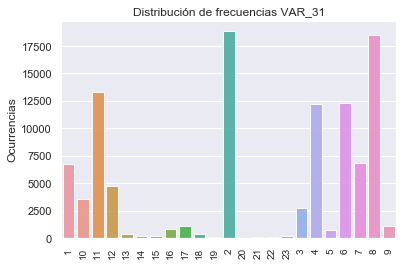

<Figure size 864x576 with 0 Axes>

Información de: VAR_31
Nº de registros: 105068
Registros únicos: 23
Moda: 2
Frecuencia de la moda: 18%
Frecuencia media de los registros únicos (excepto la moda): 4%




In [65]:
dist_freq('VAR_31')
info_vars('VAR_31')

In [66]:
def var_31_func(x):

    if x in ('20','8','6','4','2'):
        return "1"
    elif x in ('11','7','1'):
        return "2"
    elif x in ('10','12','3'):
        return "3"
    elif x in ('9','16','18','5'):
        return "4"
    else:
        return "4"
    
A_cat.loc[:,"VAR_31_2"] = A_cat["VAR_31"].apply(lambda x: var_31_func(x))

In [67]:
# Se comprueba que la función es correcta:

A_cat.groupby('VAR_31_2')['VAR_31_2'].count()

VAR_31_2
1    61893
2    26948
3    10970
4     5257
Name: VAR_31_2, dtype: int64

In [68]:
# Se eliminan las variables intermedias:

A_cat = A_cat.drop(['VAR_31'], axis=1)
A_cat = A_cat.rename(columns={'VAR_31_2': 'VAR_31'})

#### VAR_37:

Se agrupan los valores: 4, 5, 6 y más de 6.

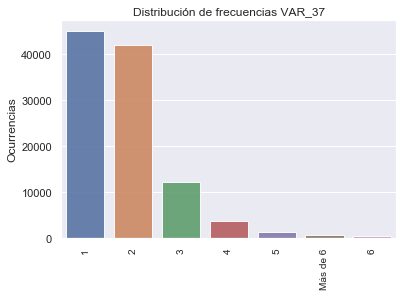

<Figure size 864x576 with 0 Axes>

Información de: VAR_37
Nº de registros: 105068
Registros únicos: 7
Moda: 1
Frecuencia de la moda: 43%
Frecuencia media de los registros únicos (excepto la moda): 8%




In [69]:
dist_freq('VAR_37')
info_vars('VAR_37')

In [70]:
def var_37_func(x):

    if x == '1':
        return "1"
    elif x == '2':
        return "2"
    elif x == '3':
        return "3"
    else:
        return "4 o mas"
    
A_cat.loc[:,"VAR_37_2"] = A_cat["VAR_37"].apply(lambda x: var_37_func(x))

In [71]:
# Se comprueba que la función es correcta:

A_cat.groupby('VAR_37_2')['VAR_37_2'].count()

VAR_37_2
1          45040
2          41889
3          12093
4 o mas     6046
Name: VAR_37_2, dtype: int64

In [72]:
# Se eliminan las variables intermedias:

A_cat = A_cat.drop(['VAR_37'], axis=1)
A_cat = A_cat.rename(columns={'VAR_37_2': 'VAR_37'})

#### VAR_95:

Se agrupan los valores 0 y 1 y 3 y 4.

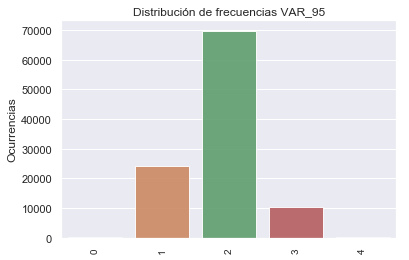

<Figure size 864x576 with 0 Axes>

Información de: VAR_95
Nº de registros: 105068
Registros únicos: 5
Moda: 2
Frecuencia de la moda: 66%
Frecuencia media de los registros únicos (excepto la moda): 7%




In [73]:
dist_freq('VAR_95')
info_vars('VAR_95')

In [74]:
def var_95_func(x):

    if x in ('0','1'):
        return "1"
    elif x == '2':
        return "2"
    elif x == '3':
        return "3"
    else:
        return "3"
    
A_cat.loc[:,"VAR_95_2"] = A_cat["VAR_95"].apply(lambda x: var_95_func(x))

In [75]:
# Se comprueba que la función es correcta:

A_cat.groupby('VAR_95_2')['VAR_95_2'].count()

VAR_95_2
1    24480
2    69861
3    10727
Name: VAR_95_2, dtype: int64

In [76]:
# Se eliminan las variables intermedias:

A_cat = A_cat.drop(['VAR_95'], axis=1)
A_cat = A_cat.rename(columns={'VAR_95_2': 'VAR_95'})

### Matriz de correlación

Se crea una nueva variable con el target en forma numérica para poder aplicar estudiar su correlación con el resto de
variables numéricas:

In [77]:
A_cat['VAR_43_B'] = A_cat['VAR_43_NIVELADO'].astype(str).astype(int)

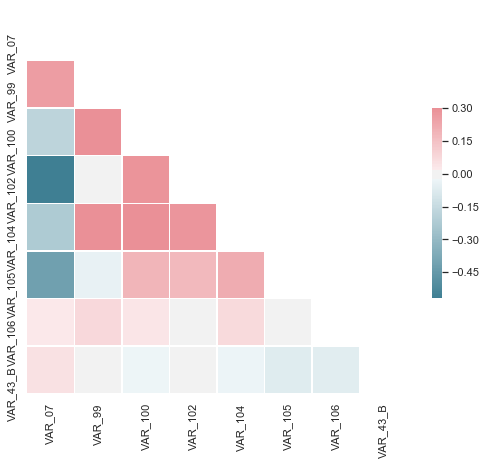

In [78]:
sns.set(style="white")

# Se calcula la matriz de correlación
corr = A_cat.corr()

# Se genera la estructura triangular de la matriz de correlación
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Se crea la figura con matplotlib
f, ax = plt.subplots(figsize=(9, 7))

# Se genera la paleta de colores
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Se dibuja el mapa de calor
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 5. Mean encoding:

Al tratamiento necesario para que las variables categóricas puedan ser entendidas por los algoritmos se le conoce como _encoding_.

Debido al gran número de variables categóricas que hay en mi dataset y a que cada una de ellas tiene bastantes posibles valores, he optado por emplear **_mean encoding_**.

Para cada valor de la variable categórica, _mean encoding_ relaciona el ratio de ocurrencia con la clase positiva del target. Esta nueva variable representa la probabilidad de que se de la clase positiva del target condicionada a cada valor de la variable categórica. 

A diferencia del _one hot encoding_ (que genera una nueva variable por cada posible valor de cada variable categórica), mean encoding genera 4 nuevas columnas por cada variable (una por cada posible valor del target).

Para la realización de esta parte del código me he basado en la siguiente web: https://necromuralist.github.io/kaggle-competitions/posts/mean-encoding/





Antes de empezar con el mean encoding, se eliminan algunas variables que, una vez analizadas, no resultan representativas: VAR_11, VAR_25 y VAR_29.

In [79]:
A_cat = A_cat.drop(['VAR_11', 'VAR_25', 'VAR_29', 'VAR_87', 'VAR_13', 'VAR_43_B'], axis=1)

**Se elabora el código del _mean encoding_ para la parte de entrenamiento:**

In [150]:

from sklearn.model_selection import KFold, StratifiedKFold

# Se seleccionan las variables categóricas no binarias a las que se les va a aplicar mean encoding:

vars_cat_no_binarias = ['VAR_01', 'VAR_02', 'VAR_03', 'VAR_04', 'VAR_05', 'VAR_06', 'VAR_08', 'VAR_09', 'VAR_10',
                                  'VAR_14', 'VAR_15', 'VAR_20', 'VAR_21', 'VAR_23', 'VAR_24', 'VAR_26', 'VAR_30', 'VAR_31',
                                  'VAR_32', 'VAR_33', 'VAR_34', 'VAR_36', 'VAR_37', 'VAR_38', 'VAR_39', 'VAR_40', 'VAR_41',
                                  'VAR_42', 'VAR_88', 'VAR_89', 'VAR_91', 'VAR_92', 'VAR_93', 'VAR_94', 'VAR_95', 'VAR_96',
                                  'VAR_97', 'VAR_98', 'VAR_101','VAR_103']

# Se separa la base de datos en entrenamiento y test

msk = np.random.rand(len(A_cat)) < 0.8
training = A_cat[msk]
test = A_cat[~msk]

# Mi target es "VAR_43_NIVELADO"

y_train = training['VAR_43_NIVELADO'].values

# Shuffle barajea-. Fijamos semilla para que sea la misma partición para todos los valores del target

folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=362) 

# Se crea una copia del dataframe donde se guardarán las nuevas columnas

train_new = training.copy()

# Se establece un alpha para el smoothing

alpha = 50

# Bucle for para cada valor del target:

for target in np.array(['1', '2', '3', '4']):
    
    print(target)
    
    global_mean = (training['VAR_43_NIVELADO']==target).mean()
    
    for column in vars_cat_no_binarias:
        train_new[column + "_mean_target_" + target] = 0
    
# Mean encoding con Cross-Validation.
        
    for training_index, validation_index in folds.split(y_train, y_train):
        x_train = training.iloc[training_index]
        x_validation = training.iloc[validation_index]

        for column in vars_cat_no_binarias:
            means = x_validation[column].map(\
                        x_train.apply(lambda x: x['VAR_43_NIVELADO']==target, axis=1).groupby(x_train[column]).mean())
            nrows = x_validation[column].map(\
                        x_train.apply(lambda x: x['VAR_43_NIVELADO']==target, axis=1).groupby(x_train[column]).count())

            train_new.loc[train_new.index[validation_index],column + "_mean_target_" + target] = \
            (means*nrows+global_mean*alpha)/(nrows+alpha)

""" Se sustituyen los posibles Nan`s con la media global (que el tramiento general de missings para el resto de variables
ya está hecho.)"""
    
train_new.fillna(global_mean, inplace=True)

train_new.head()

1
2
3
4


,VAR_01,VAR_02,VAR_04,VAR_05,VAR_06,VAR_07,VAR_08,VAR_10,VAR_12,VAR_14,VAR_15,VAR_16,VAR_17,VAR_18,VAR_19,VAR_20,VAR_22,VAR_23,VAR_24,VAR_26,VAR_27,VAR_28,VAR_30,VAR_32,VAR_33,VAR_34,VAR_36,VAR_38,VAR_39,VAR_40,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78,VAR_79,VAR_80,VAR_81,VAR_82,VAR_83,VAR_84,VAR_85,VAR_86,VAR_88,VAR_89,VAR_90,VAR_91,VAR_92,VAR_93,VAR_94,VAR_96,VAR_97,VAR_98,VAR_99,VAR_100,VAR_101,VAR_102,VAR_103,VAR_104,VAR_105,VAR_106,VAR_43_NIVELADO,VAR_03,VAR_09,VAR_21,VAR_31,VAR_37,VAR_95,VAR_01_mean_target_1,VAR_02_mean_target_1,VAR_03_mean_target_1,VAR_04_mean_target_1,VAR_05_mean_target_1,VAR_06_mean_target_1,VAR_08_mean_target_1,VAR_09_mean_target_1,VAR_10_mean_target_1,VAR_14_mean_target_1,VAR_15_mean_target_1,VAR_20_mean_target_1,VAR_21_mean_target_1,VAR_23_mean_target_1,VAR_24_mean_target_1,VAR_26_mean_target_1,VAR_30_mean_target_1,VAR_31_mean_target_1,VAR_32_mean_target_1,VAR_33_mean_target_1,VAR_34_mean_target_1,VAR_36_mean_target_1,VAR_37_mean_target_1,VAR_38_mean_target_1,VAR_39_mean_target_1,VAR_40_mean_target_1,VAR_41_mean_target_1,VAR_42_mean_target_1,VAR_88_mean_target_1,VAR_89_mean_target_1,VAR_91_mean_target_1,VAR_92_mean_target_1,VAR_93_mean_target_1,VAR_94_mean_target_1,VAR_95_mean_target_1,VAR_96_mean_target_1,VAR_97_mean_target_1,VAR_98_mean_target_1,VAR_101_mean_target_1,VAR_103_mean_target_1,VAR_01_mean_target_2,VAR_02_mean_target_2,VAR_03_mean_target_2,VAR_04_mean_target_2,VAR_05_mean_target_2,VAR_06_mean_target_2,VAR_08_mean_target_2,VAR_09_mean_target_2,VAR_10_mean_target_2,VAR_14_mean_target_2,VAR_15_mean_target_2,VAR_20_mean_target_2,VAR_21_mean_target_2,VAR_23_mean_target_2,VAR_24_mean_target_2,VAR_26_mean_target_2,VAR_30_mean_target_2,VAR_31_mean_target_2,VAR_32_mean_target_2,VAR_33_mean_target_2,VAR_34_mean_target_2,VAR_36_mean_target_2,VAR_37_mean_target_2,VAR_38_mean_target_2,VAR_39_mean_target_2,VAR_40_mean_target_2,VAR_41_mean_target_2,VAR_42_mean_target_2,VAR_88_mean_target_2,VAR_89_mean_target_2,VAR_91_mean_target_2,VAR_92_mean_target_2,VAR_93_mean_target_2,VAR_94_mean_target_2,VAR_95_mean_target_2,VAR_96_mean_target_2,VAR_97_mean_target_2,VAR_98_mean_target_2,VAR_101_mean_target_2,VAR_103_mean_target_2,VAR_01_mean_target_3,VAR_02_mean_target_3,VAR_03_mean_target_3,VAR_04_mean_target_3,VAR_05_mean_target_3,VAR_06_mean_target_3,VAR_08_mean_target_3,VAR_09_mean_target_3,VAR_10_mean_target_3,VAR_14_mean_target_3,VAR_15_mean_target_3,VAR_20_mean_target_3,VAR_21_mean_target_3,VAR_23_mean_target_3,VAR_24_mean_target_3,VAR_26_mean_target_3,VAR_30_mean_target_3,VAR_31_mean_target_3,VAR_32_mean_target_3,VAR_33_mean_target_3,VAR_34_mean_target_3,VAR_36_mean_target_3,VAR_37_mean_target_3,VAR_38_mean_target_3,VAR_39_mean_target_3,VAR_40_mean_target_3,VAR_41_mean_target_3,VAR_42_mean_target_3,VAR_88_mean_target_3,VAR_89_mean_target_3,VAR_91_mean_target_3,VAR_92_mean_target_3,VAR_93_mean_target_3,VAR_94_mean_target_3,VAR_95_mean_target_3,VAR_96_mean_target_3,VAR_97_mean_target_3,VAR_98_mean_target_3,VAR_101_mean_target_3,VAR_103_mean_target_3,VAR_01_mean_target_4,VAR_02_mean_target_4,VAR_03_mean_target_4,VAR_04_mean_target_4,VAR_05_mean_target_4,VAR_06_mean_target_4,VAR_08_mean_target_4,VAR_09_mean_target_4,VAR_10_mean_target_4,VAR_14_mean_target_4,VAR_15_mean_target_4,VAR_20_mean_target_4,VAR_21_mean_target_4,VAR_23_mean_target_4,VAR_24_mean_target_4,VAR_26_mean_target_4,VAR_30_mean_target_4,VAR_31_mean_target_4,VAR_32_mean_target_4,VAR_33_mean_target_4,VAR_34_mean_target_4,VAR_36_mean_target_4,VAR_37_mean_target_4,VAR_38_mean_target_4,VAR_39_mean_target_4,VAR_40_mean_target_4,VAR_41_mean_target_4,VAR_42_mean_target_4,VAR_88_mean_target_4,VAR_89_mean_target_4,VAR_91_mean_target_4,VAR_92_mean_target_4,VAR_93_mean_target_4,VAR_94_mean_target_4,VAR_95_mean_target_4,VAR_96_mean_tar

**Se crea un diccionario con la media de cada posible valor de cada variable categórica con los valores que puede tomar el target para pasárselo a la parte de test:**

In [151]:
diccionario = {}

for column in vars_cat_no_binarias:
    
    diccionario[column] = train_new.loc[:,
              [column, column + '_mean_target_1', column + '_mean_target_2', column + '_mean_target_3',
                column + '_mean_target_4']]\
    .groupby(column).mean().to_dict()

Ahora se pasa el diccionario elaborado previamente a la parte de test y se eliminan las variables categóricas a las que se les ha aplicado _mean encoding_

In [152]:
test_new = test.copy()

for column, dict_col in diccionario.items():
    for new_column, dict_newvar in dict_col.items():
        test_new.loc[:, new_column] = test_new.loc[:, column].map(dict_newvar)
        
test_new.fillna(global_mean, inplace=True)          

## 6. Selección de variables:

Como método de selección de variables se emplea una técnica basada en árboles de decisión. Se opta por este método por su interpretabilidad.

In [153]:
# Antes de empezar con la selección de variables se eliminan algunas que no son necesarias:

cols_to_drop = vars_cat_no_binarias + ['VAR_43'] + ['VAR_27'] + ['VAR_28']

train_new = train_new.drop(cols_to_drop, axis=1)

# Se eliminan también del test:

test_new = test_new.drop(cols_to_drop, axis=1)

In [154]:
# Se comprueba que se ha realizado correctamente:

train_new.head()

,VAR_07,VAR_12,VAR_16,VAR_17,VAR_18,VAR_19,VAR_22,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78,VAR_79,VAR_80,VAR_81,VAR_82,VAR_83,VAR_84,VAR_85,VAR_86,VAR_90,VAR_99,VAR_100,VAR_102,VAR_104,VAR_105,VAR_106,VAR_43_NIVELADO,VAR_01_mean_target_1,VAR_02_mean_target_1,VAR_03_mean_target_1,VAR_04_mean_target_1,VAR_05_mean_target_1,VAR_06_mean_target_1,VAR_08_mean_target_1,VAR_09_mean_target_1,VAR_10_mean_target_1,VAR_14_mean_target_1,VAR_15_mean_target_1,VAR_20_mean_target_1,VAR_21_mean_target_1,VAR_23_mean_target_1,VAR_24_mean_target_1,VAR_26_mean_target_1,VAR_30_mean_target_1,VAR_31_mean_target_1,VAR_32_mean_target_1,VAR_33_mean_target_1,VAR_34_mean_target_1,VAR_36_mean_target_1,VAR_37_mean_target_1,VAR_38_mean_target_1,VAR_39_mean_target_1,VAR_40_mean_target_1,VAR_41_mean_target_1,VAR_42_mean_target_1,VAR_88_mean_target_1,VAR_89_mean_target_1,VAR_91_mean_target_1,VAR_92_mean_target_1,VAR_93_mean_target_1,VAR_94_mean_target_1,VAR_95_mean_target_1,VAR_96_mean_target_1,VAR_97_mean_target_1,VAR_98_mean_target_1,VAR_101_mean_target_1,VAR_103_mean_target_1,VAR_01_mean_target_2,VAR_02_mean_target_2,VAR_03_mean_target_2,VAR_04_mean_target_2,VAR_05_mean_target_2,VAR_06_mean_target_2,VAR_08_mean_target_2,VAR_09_mean_target_2,VAR_10_mean_target_2,VAR_14_mean_target_2,VAR_15_mean_target_2,VAR_20_mean_target_2,VAR_21_mean_target_2,VAR_23_mean_target_2,VAR_24_mean_target_2,VAR_26_mean_target_2,VAR_30_mean_target_2,VAR_31_mean_target_2,VAR_32_mean_target_2,VAR_33_mean_target_2,VAR_34_mean_target_2,VAR_36_mean_target_2,VAR_37_mean_target_2,VAR_38_mean_target_2,VAR_39_mean_target_2,VAR_40_mean_target_2,VAR_41_mean_target_2,VAR_42_mean_target_2,VAR_88_mean_target_2,VAR_89_mean_target_2,VAR_91_mean_target_2,VAR_92_mean_target_2,VAR_93_mean_target_2,VAR_94_mean_target_2,VAR_95_mean_target_2,VAR_96_mean_target_2,VAR_97_mean_target_2,VAR_98_mean_target_2,VAR_101_mean_target_2,VAR_103_mean_target_2,VAR_01_mean_target_3,VAR_02_mean_target_3,VAR_03_mean_target_3,VAR_04_mean_target_3,VAR_05_mean_target_3,VAR_06_mean_target_3,VAR_08_mean_target_3,VAR_09_mean_target_3,VAR_10_mean_target_3,VAR_14_mean_target_3,VAR_15_mean_target_3,VAR_20_mean_target_3,VAR_21_mean_target_3,VAR_23_mean_target_3,VAR_24_mean_target_3,VAR_26_mean_target_3,VAR_30_mean_target_3,VAR_31_mean_target_3,VAR_32_mean_target_3,VAR_33_mean_target_3,VAR_34_mean_target_3,VAR_36_mean_target_3,VAR_37_mean_target_3,VAR_38_mean_target_3,VAR_39_mean_target_3,VAR_40_mean_target_3,VAR_41_mean_target_3,VAR_42_mean_target_3,VAR_88_mean_target_3,VAR_89_mean_target_3,VAR_91_mean_target_3,VAR_92_mean_target_3,VAR_93_mean_target_3,VAR_94_mean_target_3,VAR_95_mean_target_3,VAR_96_mean_target_3,VAR_97_mean_target_3,VAR_98_mean_target_3,VAR_101_mean_target_3,VAR_103_mean_target_3,VAR_01_mean_target_4,VAR_02_mean_target_4,VAR_03_mean_target_4,VAR_04_mean_target_4,VAR_05_mean_target_4,VAR_06_mean_target_4,VAR_08_mean_target_4,VAR_09_mean_target_4,VAR_10_mean_target_4,VAR_14_mean_target_4,VAR_15_mean_target_4,VAR_20_mean_target_4,VAR_21_mean_target_4,VAR_23_mean_target_4,VAR_24_mean_target_4,VAR_26_mean_target_4,VAR_30_mean_target_4,VAR_31_mean_target_4,VAR_32_mean_target_4,VAR_33_mean_target_4,VAR_34_mean_target_4,VAR_36_mean_target_4,VAR_37_mean_target_4,VAR_38_mean_target_4,VAR_39_mean_target_4,VAR_40_mean_target_4,VAR_41_mean_target_4,VAR_42_mean_target_4,VAR_88_mean_target_4,VAR_89_mean_target_4,VAR_91_mean_target_4,VAR_92_mean_target_4,VAR_93_mean_target_4,VAR_94_mean_target_4,VAR_95_mean_target_4,VAR_96_mean_target_4,VAR_97_mean_target_4,VAR_98_mean_target_4,VAR_101_mean_target_4,VAR_103_mean_target_4
0,1.0,28018,0,0,0,0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,11.0,1968.0,150.0,110.0,40177.0,107.0,43,3,0.369012,0.422476,0.389302,0.360357,0.451477,0.365898,0.44

Para poder aplicar esta técnica de selección de variables, **primero se han de estandarizar las variables de tipo continuo:**

In [155]:
# Se seleccionan aquellas features de tipo continuo:

var_continuas = train_new.columns[train_new.dtypes != object]

In [156]:
from sklearn import preprocessing

common_scaler = preprocessing.StandardScaler()

for var in var_continuas:
    
    train_new[var + "_standarized"] = common_scaler.fit_transform(train_new[var].values.reshape(-1,1))
    
    test_new[var + "_standarized"] = common_scaler.fit_transform(test_new[var].values.reshape(-1,1))

train_new.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,VAR_07,VAR_12,VAR_16,VAR_17,VAR_18,VAR_19,VAR_22,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50,VAR_51,VAR_52,VAR_53,VAR_54,VAR_55,VAR_56,VAR_57,VAR_58,VAR_59,VAR_60,VAR_61,VAR_62,VAR_63,VAR_64,VAR_65,VAR_66,VAR_67,VAR_68,VAR_69,VAR_70,VAR_71,VAR_72,VAR_73,VAR_74,VAR_75,VAR_76,VAR_77,VAR_78,VAR_79,VAR_80,VAR_81,VAR_82,VAR_83,VAR_84,VAR_85,VAR_86,VAR_90,VAR_99,VAR_100,VAR_102,VAR_104,VAR_105,VAR_106,VAR_43_NIVELADO,VAR_01_mean_target_1,VAR_02_mean_target_1,VAR_03_mean_target_1,VAR_04_mean_target_1,VAR_05_mean_target_1,VAR_06_mean_target_1,VAR_08_mean_target_1,VAR_09_mean_target_1,VAR_10_mean_target_1,VAR_14_mean_target_1,VAR_15_mean_target_1,VAR_20_mean_target_1,VAR_21_mean_target_1,VAR_23_mean_target_1,VAR_24_mean_target_1,VAR_26_mean_target_1,VAR_30_mean_target_1,VAR_31_mean_target_1,VAR_32_mean_target_1,VAR_33_mean_target_1,VAR_34_mean_target_1,VAR_36_mean_target_1,VAR_37_mean_target_1,VAR_38_mean_target_1,VAR_39_mean_target_1,VAR_40_mean_target_1,VAR_41_mean_target_1,VAR_42_mean_target_1,VAR_88_mean_target_1,VAR_89_mean_target_1,VAR_91_mean_target_1,VAR_92_mean_target_1,VAR_93_mean_target_1,VAR_94_mean_target_1,VAR_95_mean_target_1,VAR_96_mean_target_1,VAR_97_mean_target_1,VAR_98_mean_target_1,VAR_101_mean_target_1,VAR_103_mean_target_1,VAR_01_mean_target_2,VAR_02_mean_target_2,VAR_03_mean_target_2,VAR_04_mean_target_2,VAR_05_mean_target_2,VAR_06_mean_target_2,VAR_08_mean_target_2,VAR_09_mean_target_2,VAR_10_mean_target_2,VAR_14_mean_target_2,VAR_15_mean_target_2,VAR_20_mean_target_2,VAR_21_mean_target_2,VAR_23_mean_target_2,VAR_24_mean_target_2,VAR_26_mean_target_2,VAR_30_mean_target_2,VAR_31_mean_target_2,VAR_32_mean_target_2,VAR_33_mean_target_2,VAR_34_mean_target_2,VAR_36_mean_target_2,VAR_37_mean_target_2,VAR_38_mean_target_2,VAR_39_mean_target_2,VAR_40_mean_target_2,VAR_41_mean_target_2,VAR_42_mean_target_2,VAR_88_mean_target_2,VAR_89_mean_target_2,VAR_91_mean_target_2,VAR_92_mean_target_2,VAR_93_mean_target_2,VAR_94_mean_target_2,VAR_95_mean_target_2,VAR_96_mean_target_2,VAR_97_mean_target_2,VAR_98_mean_target_2,VAR_101_mean_target_2,VAR_103_mean_target_2,VAR_01_mean_target_3,VAR_02_mean_target_3,VAR_03_mean_target_3,VAR_04_mean_target_3,VAR_05_mean_target_3,VAR_06_mean_target_3,VAR_08_mean_target_3,VAR_09_mean_target_3,VAR_10_mean_target_3,VAR_14_mean_target_3,VAR_15_mean_target_3,VAR_20_mean_target_3,VAR_21_mean_target_3,VAR_23_mean_target_3,VAR_24_mean_target_3,VAR_26_mean_target_3,VAR_30_mean_target_3,VAR_31_mean_target_3,VAR_32_mean_target_3,VAR_33_mean_target_3,VAR_34_mean_target_3,VAR_36_mean_target_3,VAR_37_mean_target_3,VAR_38_mean_target_3,VAR_39_mean_target_3,VAR_40_mean_target_3,VAR_41_mean_target_3,VAR_42_mean_target_3,VAR_88_mean_target_3,VAR_89_mean_target_3,VAR_91_mean_target_3,VAR_92_mean_target_3,VAR_93_mean_target_3,VAR_94_mean_target_3,VAR_95_mean_target_3,VAR_96_mean_target_3,VAR_97_mean_target_3,VAR_98_mean_target_3,VAR_101_mean_target_3,VAR_103_mean_target_3,VAR_01_mean_target_4,VAR_02_mean_target_4,VAR_03_mean_target_4,VAR_04_mean_target_4,VAR_05_mean_target_4,VAR_06_mean_target_4,VAR_08_mean_target_4,VAR_09_mean_target_4,VAR_10_mean_target_4,VAR_14_mean_target_4,VAR_15_mean_target_4,VAR_20_mean_target_4,VAR_21_mean_target_4,VAR_23_mean_target_4,VAR_24_mean_target_4,VAR_26_mean_target_4,VAR_30_mean_target_4,VAR_31_mean_target_4,VAR_32_mean_target_4,VAR_33_mean_target_4,VAR_34_mean_target_4,VAR_36_mean_target_4,VAR_37_mean_target_4,VAR_38_mean_target_4,VAR_39_mean_target_4,VAR_40_mean_target_4,VAR_41_mean_target_4,VAR_42_mean_target_4,VAR_88_mean_target_4,VAR_89_mean_target_4,VAR_91_mean_target_4,VAR_92_mean_target_4,VAR_93_mean_target_4,VAR_94_mean_target_4,VAR_95_mean_target_4,VAR_96_mean_target_4,VAR_97_mean_target_4,VAR_98_mean_target_4,VAR_101_mean_target_4,VAR_103_mean_target_4,VAR_07_standarized,VAR_99_standarized,VAR_100_standarized,VAR_102_standarized,VAR_104_standarized,VAR_105_standarized,VAR_106_standarized,VAR_01_mean_target_1_standarized,VAR_02_mean_target_1_standarized,VAR_03_

Una vez comprobado que la estandarización se ha realizado correctamente, se eliminan las variables de tipo continuo a las que se les ha aplicado.

In [157]:
train_new = train_new.drop(var_continuas, axis=1)
test_new = test_new.drop(var_continuas, axis=1)

train_new.shape

(84118, 218)

**Se emplea un `randomforesclassifier()` como técnica para hacer la selección de variables:**

In [158]:
from sklearn.ensemble import RandomForestClassifier

Se separan las features y el target en el dataset de entrenamiento:

In [159]:
y_train = train_new['VAR_43_NIVELADO']
X_train = train_new.drop('VAR_43_NIVELADO', axis=1)

In [160]:
y_test = test_new['VAR_43_NIVELADO']
X_test = test_new.drop('VAR_43_NIVELADO', axis=1)

In [161]:
randomforest = RandomForestClassifier(n_estimators = 100, random_state=0, n_jobs=-1)
model = randomforest.fit(X_train, y_train)

En esta técnica, **las variables más relevantes son aquellas que más contribuyen a disminuir la impureza** (medida con el coeficiente de Gini):

In [162]:
# Se obtiene la importancia de las variables y se ordenan de mayor a menor:

importancia_variables = model.feature_importances_
indices = np.argsort(importancia_variables)[::-1]
nombres = [X_train.columns[i] for i in indices]

Se dibuja un gráfico donde cada barra representa la contribución de cada variable a reducir la impureza:

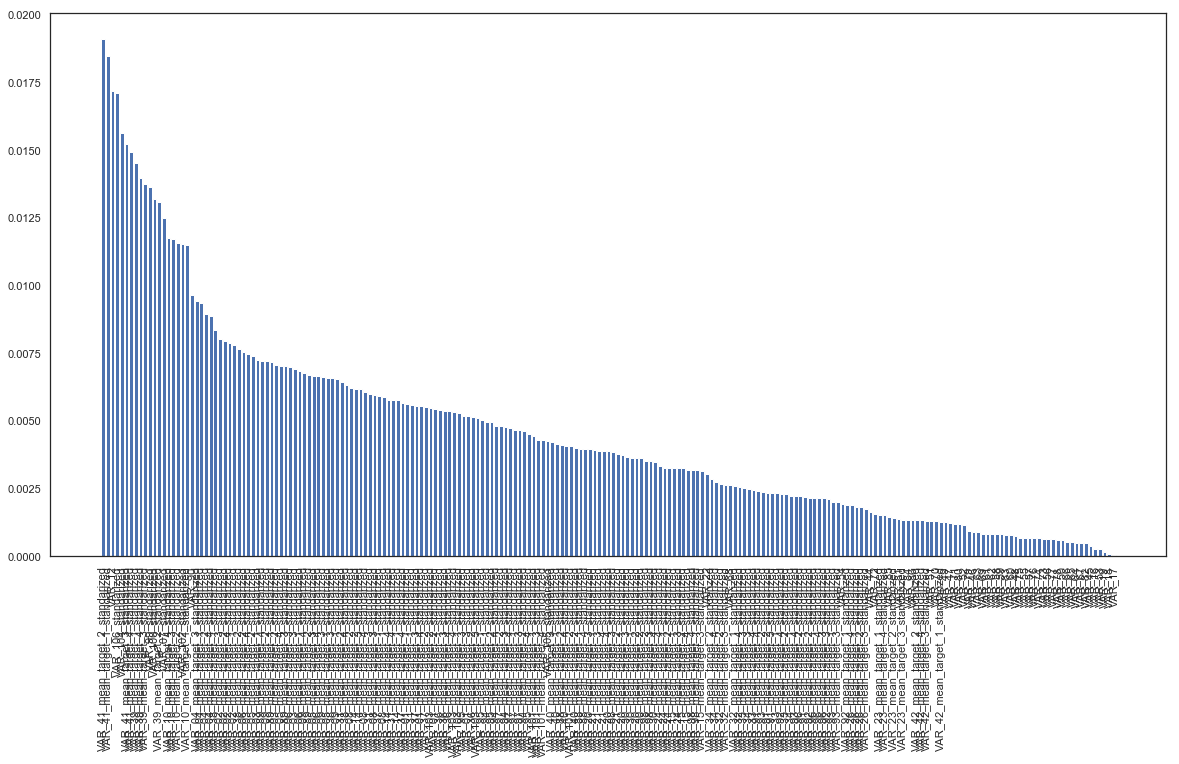

In [163]:
plt.figure(figsize=(20,10))
plt.bar(range(X_train.shape[1]), importancia_variables[indices])
plt.xticks(range(X_train.shape[1]), nombres, rotation=90)
plt.show()

Se seleccionan aquellas **estableciendo un threshold del 0.003**

La suma de estas **resume el 87% de la impureza de los datos.**

In [164]:
importancia_variables_2 = importancia_variables[importancia_variables>0.003]
indices_2 = np.argsort(importancia_variables_2)[::-1]
indices_2
nombres_2 = [X_train.columns[i] for i in indices_2]

importancia_variables_2.sum()

0.8747470023166001

Se dibuja el gráfico de importancia con las variables seleccionadas:

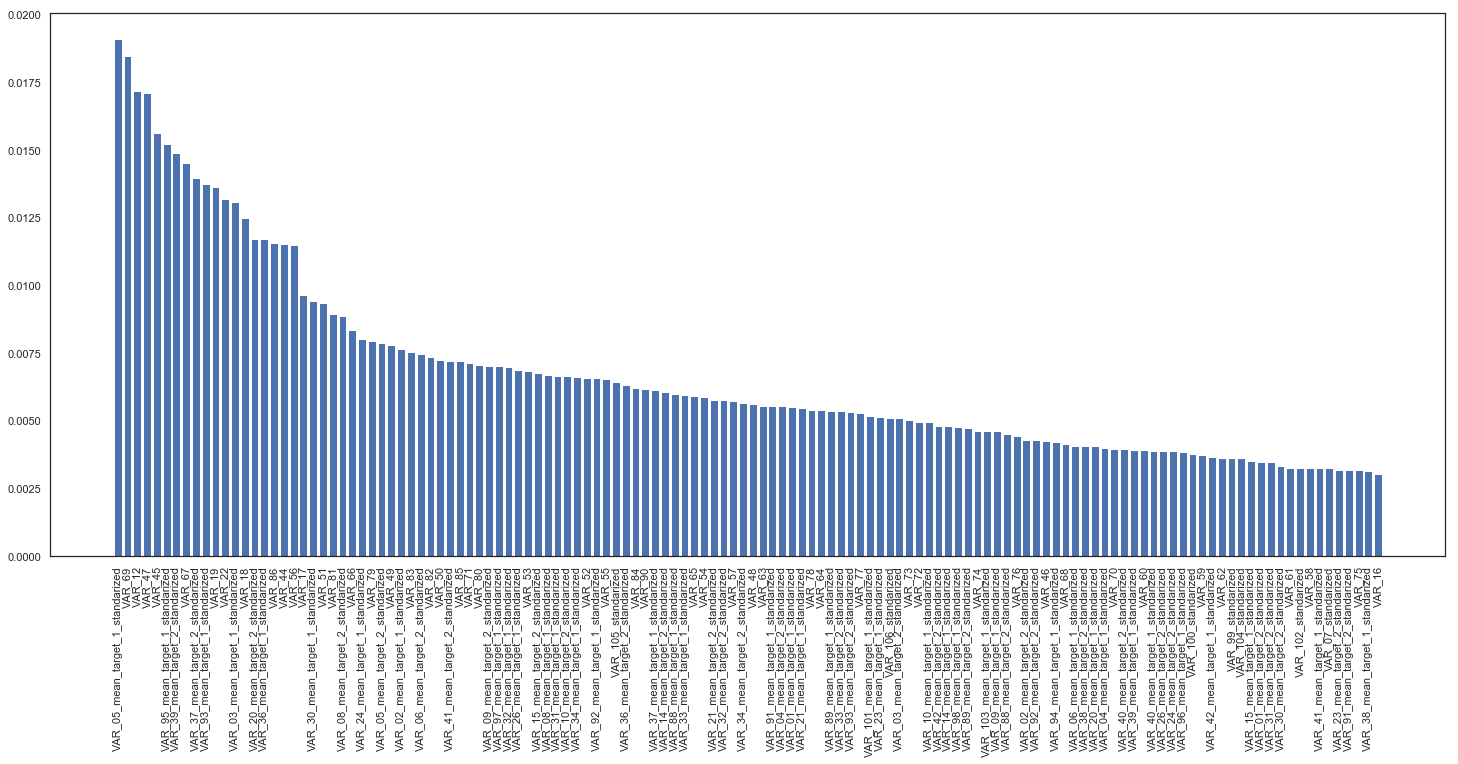

In [165]:
plt.figure(figsize=(25,10))
plt.bar(range(len(nombres_2)), importancia_variables_2[indices_2])
plt.xticks(range(len(nombres_2)), nombres_2, rotation=90)
plt.show()

**Se crean los nuevos datasets de entrenamiento con las variables seleccionadas:**

In [166]:
X_train_2 = X_train.loc[:,nombres_2]
X_test_2 = X_test.loc[:,nombres_2]

Mediante la aplicación de esta técnica, se dejan de tener en cuenta 86 variables:

In [243]:
print(X_train.shape[1] - X_train_2.shape[1])

87


In [167]:
print(X_test.shape[1] - X_test_2.shape[1])

87


**Preprocesado del test**

In [95]:
""" Estandarizado del test:

for var in var_continuas:
    test_new[var + "_standarized"] = common_scaler.fit_transform(test_new[var].values.reshape(-1,1))

test_new = test_new.drop(var_continuas, axis=1)

# Separación de features y target:

y_test = test_new['VAR_43_NIVELADO']
X_test = test_new.drop('VAR_43_NIVELADO', axis=1)

# Selección de variables

X_test_2 = X_test.loc[:,nombres_2]"""

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 7. Modelización:

Antes de aplicar ningún modelo, se estudia cuál sería el acierto si siempre se escogiese la clase mayoritaria (valor 1 del target). **A este valor también se le conoce como el acierto del modelo Naive:**

In [132]:
y_train.groupby(y_train).size()/y_train.shape[0]

VAR_43_NIVELADO
1    0.412965
2    0.389109
3    0.110232
4    0.087694
Name: VAR_43_NIVELADO, dtype: float64

Si siempre se escogiese la clase mayoritaria del target **se estaría acertando en el 41,2% de los casos.** Este es el valor contra el que vamos a comparar los modelos generados a continuación.

#### 7.1 Se realiza una regresión logística multiclase como baseline:

In [133]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(random_state=0, multi_class="ovr")

modelo_1 = logistic_regression.fit(X_train_2, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [134]:
modelo_1.score

<bound method ClassifierMixin.score of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)>

El _accuracy_ del primer modelo es del **51,7%:**

In [135]:
cross_val_score(modelo_1, X_train_2, y_train, scoring="accuracy").mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5168205043719718

In [115]:
pred_log_2 = model_1.predict_proba(X_2)

In [116]:
positions_pred_impago = np.argsort(pred_log_2[:,3])[::-1]

In [117]:
np.mean(y.iloc[positions_pred_impago[:int(0.05*y.shape[0])]]=='4')

0.2512479201331115

In [118]:
np.sum(y.iloc[positions_pred_impago[:int(0.1*y.shape[0])]]=='4')/np.sum(y=='4')

0.2575255454294394

In [119]:
y.groupby(y).size()/y.shape[0]

VAR_43_NIVELADO
1    0.413955
2    0.390000
3    0.109994
4    0.086051
Name: VAR_43_NIVELADO, dtype: float64

### Random Forest:

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [137]:
param_grid = {
    
    'n_estimators': [50, 100, 200, 400, 600, 800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8, 9, 10, 11, 12],
    'bootstrap' : [True, False]
}


In [138]:
%%time

rforestcl = RandomizedSearchCV(RandomForestClassifier(),
    scoring='accuracy',
    cv=4,
    param_distributions = param_grid,
    n_jobs=-1,
    verbose=True
)
rforestcl.fit(X_train_2, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.0min finished


Wall time: 6min 36s


In [139]:
rforestcl.best_score_

0.5210478192203104

In [140]:
rforestcl.best_params_

{'n_estimators': 800,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': True}

### SVM:

In [141]:
"""from sklearn.svm import SVC

param_grid_svm = {
    "C": np.logspace(-2, 2, 5),
}

svmcl = GridSearchCV(SVC(kernel="rbf"),
    param_grid = param_grid_svm,
    cv=4,
    scoring="accuracy")

svmcl.fit(X_2, y)

svmcl.best_score_

svmcl.best_params_"""

'from sklearn.svm import SVC\n\nparam_grid_svm = {\n    "C": np.logspace(-2, 2, 5),\n}\n\nsvmcl = GridSearchCV(SVC(kernel="rbf"),\n    param_grid = param_grid_svm,\n    cv=4,\n    scoring="accuracy")\n\nsvmcl.fit(X_2, y)\n\nsvmcl.best_score_\n\nsvmcl.best_params_'

Tratamiento de datos para poder aplicar el XGBoost:

In [168]:
var_objetc = X_train_2.columns[X_train_2.dtypes == object]
var_objetc_test = X_test_2.columns[X_test_2.dtypes == object]

In [169]:
var_objetc == var_objetc_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [170]:
var_objetc = X_train_2.columns[X_train_2.dtypes == object]
X_train_2.loc[:, var_objetc] = X_train_2.loc[:, var_objetc].astype('float64')

In [171]:
var_objetc = X_train_2.columns[X_train_2.dtypes == object]
var_objetc

Index([], dtype='object')

In [172]:
var_objetc_test = X_test_2.columns[X_test_2.dtypes == object]
X_test_2.loc[:, var_objetc_test] = X_test_2.loc[:, var_objetc_test].astype('float64')

In [173]:
var_objetc_test = X_test_2.columns[X_test_2.dtypes == object]
var_objetc_test

Index([], dtype='object')

In [174]:
X_train_2.columns == X_test_2.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [185]:
from xgboost import XGBClassifier

In [186]:
param_grid_xgb = {
    
    'n_estimators': [200, 500, 800, 1000],
    'max_depth' : [4, 5, 6, 7, 8, 9, 10, 11, 12],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'learning_rate': [0.01, 0.05],
    'gamma': [0,1,5]
}

In [189]:
%%time

xgbcl = RandomizedSearchCV(XGBClassifier(),
    scoring='accuracy',
    cv=9,
    param_distributions = param_grid_xgb,
    n_jobs=-1,
    verbose=True
)

xgbcl.fit(X_train_2, y_train)

Fitting 9 folds for each of 10 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 210.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 717.2min finished


Wall time: 12h 28min 14s


In [190]:
xgbcl.best_score_

0.5462207850876151

In [191]:
xgbcl.best_params_

{'subsample': 0.8,
 'n_estimators': 800,
 'max_depth': 7,
 'learning_rate': 0.05,
 'gamma': 5,
 'colsample_bytree': 0.8}

In [194]:
xgbcl.score(X_test_2, y_test)

0.5492601431980907

In [110]:
from sklearn.externals import joblib

In [192]:
filename = 'xgbcl_model.sav'
joblib.dump(xgbcl, filename)

['xgbcl_model.sav']

In [193]:
loaded_model = joblib.load('xgbcl_model.sav')
result = loaded_model.score(X_test_2, y_test)
print(result)

0.5492601431980907


In [195]:
y_pred = loaded_model.predict(X_test_2)

In [196]:
y_real = y_test.values

In [197]:
# Genera una muestra uniforme aleatoria con nºs del 1 a len(yreal) y tamaño len(yreal):

def bootstrap_choice(yreal):
    return np.random.choice(len(yreal),size=len(yreal),replace=True)

# Función que haya el accuracy:

def accuracy_campaign(y_real, y_pred):
    return np.mean(y_real == y_pred)

def bootstrap_statistic(yreal, prediction, n_boots): 
    
    simulation_statistic = []
    
    for i in range(n_boots):
        choices = bootstrap_choice(yreal)
        simulation_statistic += [accuracy_campaign(yreal[choices], prediction[choices])]
    return simulation_statistic

In [198]:
bootstrap_accuracy = bootstrap_statistic(y_real, y_pred, 10000)

In [199]:
np.percentile(bootstrap_accuracy, [2.5, 97.5])

array([0.54252983, 0.55603819])

In [200]:
accuracy_campaign(y_real, y_pred)

0.5492601431980907

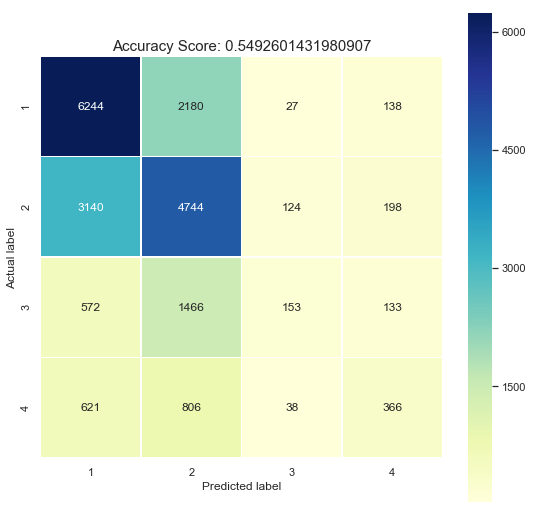

In [262]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(y_real, y_pred, class_names)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'YlGnBu',\
            xticklabels=['1','2','3','4'], yticklabels=['1','2','3','4']);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {}'.format(result)
plt.title(all_sample_title, size = 15);